# MODELING  
- Modeling a multi-layer perceptron neural network with tensoflow-keras

In [1]:
import pandas as pd

In [2]:
## load the data

df = pd.read_csv('data_modeling.csv')

df.shape

(317369, 11)

In [3]:
# check data types
df.dtypes

KUNTA                         object
Toimittajan nimi              object
Toimittajan maakoodi          object
Laskun summa ilman ALV:tä    float64
TILI                           int64
Kokonaissumma                float64
ALV-KOODI                    float64
RIVIN OSUUS VERO             float64
Kustannuspaikka               object
Tositepäivämäärä_month         int64
Tositepäivämäärä_day           int64
dtype: object

In [4]:
# convert data types for the target features into categorical
df['TILI'] = df['TILI'].astype(object)
df['ALV-KOODI'] = df['ALV-KOODI'].astype(object)

## DATA PREPARATION  
- drop missing values
    - As we discovered in the data understanding, there were some features with missing values. So, here we will simply drop the records that have missing values.
- convert categorical features to numeric
    - For machine learning modeling we need to have categorical features as numeric. For the baseline modeling we can simply use ordinal encoding for encoding categorical features as numeric.

In [5]:
from feature_engine.imputation import DropMissingData
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


In [6]:
# list categorical input features
cat_features = [feat for feat in df.columns if df[feat].dtype=='O' and feat not in ['TILI', 'ALV-KOODI']]

print(cat_features)


['KUNTA', 'Toimittajan nimi', 'Toimittajan maakoodi', 'Kustannuspaikka']


In [7]:
# create pipeline for data pre-processing
preprocessing_pipeline = Pipeline(steps=[
    
    # drop records with missing values
    ('Missing', DropMissingData()),
    
    # ordinal encoding for categorical features
    ('Ordinal_Encoding', OrdinalEncoder(encoding_method='arbitrary', variables = cat_features)),
    
    # recategorization of feature TILI
    ('Rare_label_encoding_tili', RareLabelEncoder(tol = 0.003, replace_with=1000, variables=['TILI'])),
    
     # recategorization of feature ALV-KOODI
    ('Rare_label_encoding_alv', RareLabelEncoder(tol = 0.0002, replace_with=1000, variables=['ALV-KOODI']))
    
    ] 
)

# minmax scaling the features - excluding the targets
#    ('MinMax_Scaling', SklearnTransformerWrapper(transformer=MinMaxScaler(),
#                                                 variables = [var for var in df.columns if var not in ['TILI', 'ALV-KOODI']]))

In [8]:
# fit the pipeline and transform the data

df_transformed = preprocessing_pipeline.fit_transform(df)

In [9]:
# check if any missing values
df_transformed.isnull().sum()

KUNTA                        0
Toimittajan nimi             0
Toimittajan maakoodi         0
Laskun summa ilman ALV:tä    0
TILI                         0
Kokonaissumma                0
ALV-KOODI                    0
RIVIN OSUUS VERO             0
Kustannuspaikka              0
Tositepäivämäärä_month       0
Tositepäivämäärä_day         0
dtype: int64

In [10]:
# check data for categorical features
df_transformed[cat_features].head()

,KUNTA,Toimittajan nimi,Toimittajan maakoodi,Kustannuspaikka
0,0,0,0,0
1,0,0,0,1
2,0,0,0,2
3,0,0,0,3
4,0,0,0,4


In [11]:
df_transformed.head()

,KUNTA,Toimittajan nimi,Toimittajan maakoodi,Laskun summa ilman ALV:tä,TILI,Kokonaissumma,ALV-KOODI,RIVIN OSUUS VERO,Kustannuspaikka,Tositepäivämäärä_month,Tositepäivämäärä_day
0,0,0,0,116.23,4520,132.50,114.0,16.27,0,1,8
1,0,0,0,89.78,4300,94.50,105.0,4.72,1,1,11
2,0,0,0,135.00,4340,167.40,124.0,32.40,2,1,11
3,0,0,0,149.00,4510,184.76,124.0,35.76,3,1,11
4,0,0,0,189.11,4520,215.59,114.0,26.48,4,1,12


In [12]:
# number of categories in the target feature 'TILI'
df_transformed['TILI'].nunique()

39

In [13]:
# number of categories in the target feature 'AlV-KOODI'
df_transformed['ALV-KOODI'].nunique()

15

### Tensorflow Dataset Preparation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE

In [15]:
# create train and test split
train, test = train_test_split(df_transformed, test_size=0.2, random_state = 123)

train.shape, test.shape

((249052, 11), (62263, 11))

In [16]:
# seprate input features and target for the train data

train_features = train.drop(['TILI', 'ALV-KOODI'], axis = 1)
train_target_tili = train['TILI']  # target feature TILI
train_target_alvi = train['ALV-KOODI']  # target feature alvi-koodi

train_features.shape,  train_target_tili.shape, train_target_alvi.shape


((249052, 9), (249052,), (249052,))

In [17]:
# number of unique labels in train_target_tili
train_target_tili.nunique()

39

In [18]:
# number of unique labels in train_target_alvi
train_target_alvi.nunique()

15

In [19]:
# seprate input features and target for the test data

test_features = test.drop(['TILI', 'ALV-KOODI'], axis = 1)
test_target_tili = test['TILI']  # target feature TILI
test_target_alvi = test['ALV-KOODI']  # target feature alvi-koodi

test_features.shape, test_target_tili.shape, test_target_alvi.shape

((62263, 9), (62263,), (62263,))

In [20]:
## label endcoding the targets

# label encode train and test targets for target feature tili
le_tili = LabelEncoder()
train_target_tili_le = le_tili.fit_transform(train_target_tili)
test_target_tili_le = le_tili.transform(test_target_tili)

# label encode train and test targets for target feature alv-koodi
le_alvi = LabelEncoder()
train_target_alvi_le = le_alvi.fit_transform(train_target_alvi)
test_target_alvi_le = le_alvi.transform(test_target_alvi)


In [21]:
import numpy as np
np.unique(train_target_tili_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [22]:
# create tensorflow dataset - train data

train_tf_dataset = Dataset.from_tensor_slices((train_features.values, (train_target_tili_le, train_target_alvi_le)))

# create tensorflow dataset - test data
test_tf_dataset = Dataset.from_tensor_slices((test_features.values, (test_target_tili_le, test_target_alvi_le)))

In [23]:
# mapping function to indicate the targets in the tensorflow datasets
def map_target(features, targets):
    return features, {"TILI":targets[0], "ALV-KOODI":targets[1]}

In [24]:
# map the function to indicate the targets
train_tf_dataset = train_tf_dataset.map(map_target)
test_tf_dataset = test_tf_dataset.map(map_target)

In [25]:
train_tf_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(9,), dtype=tf.float64, name=None), {'TILI': TensorSpec(shape=(), dtype=tf.int32, name=None), 'ALV-KOODI': TensorSpec(shape=(), dtype=tf.int32, name=None)})>

In [26]:
# prepare the batches of data
train_data = train_tf_dataset.shuffle(len(train)).batch(1024).prefetch(AUTOTUNE)

test_data = test_tf_dataset.batch(1024).prefetch(AUTOTUNE)

## Tensorflow - Keras Modeling

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Normalization

In [42]:
def base_model():
    
    model = tf.keras.Sequential()

    input_layer = Input(shape=(9,))

    model.add(input_layer)

    model.add(Dense(32, activation = 'relu'))

    model.add(Dense(64, activation = 'relu'))

    model.add(Dense(128, activation = 'relu'))

    return model 


In [43]:
base_model = base_model()

In [44]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                320       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
Total params: 10,752
Trainable params: 10,752
Non-trainable params: 0
_________________________________________________________________


In [45]:
## output layer for TILI
TILI_output = Dense(39, activation='softmax', name = 'TILI')(base_model.output)

In [46]:
## output for ALV-KOODI
ALV_output = Dense(15, activation='softmax', name = 'ALV-KOODI')(base_model.output)

In [47]:
final_model = tf.keras.Model(inputs = base_model.input,
                             outputs = (TILI_output, ALV_output) )

In [48]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32)           320         ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           2112        ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 128)          8320        ['dense_4[0][0]']                
                                                                                            

In [49]:
# define the losses for each of the target outputs
losses = {
    "TILI": tf.keras.losses.SparseCategoricalCrossentropy(),
    "ALV-KOODI": tf.keras.losses.SparseCategoricalCrossentropy(),
}


In [50]:
# compile the model
final_model.compile(loss=losses, optimizer = tf.keras.optimizers.Adam(learning_rate =  0.001), 
                    metrics = [tf.keras.metrics.sparse_categorical_accuracy])

In [51]:
# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


best_model = ModelCheckpoint(filepath='./best_model', save_best_only=True)

es = EarlyStopping(patience=20, min_delta=0.001, monitor = "val_loss", mode = 'min')

In [52]:
history = final_model.fit(train_data, 
                          validation_data=test_data,
                          epochs = 200,
                          callbacks = [best_model, es])

Epoch 1/200
244/244 [==============================] - 7s 23ms/step - loss: 92.3577 - TILI_loss: 51.2564 - ALV-KOODI_loss: 41.1013 - TILI_sparse_categorical_accuracy: 0.1046 - ALV-KOODI_sparse_categorical_accuracy: 0.5358 - val_loss: 13.9882 - val_TILI_loss: 11.0777 - val_ALV-KOODI_loss: 2.9105 - val_TILI_sparse_categorical_accuracy: 0.1566 - val_ALV-KOODI_sparse_categorical_accuracy: 0.6316
Epoch 2/200
244/244 [==============================] - 3s 8ms/step - loss: 31.5128 - TILI_loss: 19.0643 - ALV-KOODI_loss: 12.4486 - TILI_sparse_categorical_accuracy: 0.1523 - ALV-KOODI_sparse_categorical_accuracy: 0.6546 - val_loss: 99.7593 - val_TILI_loss: 37.8068 - val_ALV-KOODI_loss: 61.9525 - val_TILI_sparse_categorical_accuracy: 0.1046 - val_ALV-KOODI_sparse_categorical_accuracy: 0.6337
Epoch 3/200
244/244 [==============================] - 6s 20ms/step - loss: 19.1232 - TILI_loss: 13.2434 - ALV-KOODI_loss: 5.8799 - TILI_sparse_categorical_accuracy: 0.1807 - ALV-KOODI_sparse_categorical_accura

Epoch 17/200
244/244 [==============================] - 6s 19ms/step - loss: 2.8788 - TILI_loss: 2.4067 - ALV-KOODI_loss: 0.4721 - TILI_sparse_categorical_accuracy: 0.3769 - ALV-KOODI_sparse_categorical_accuracy: 0.8618 - val_loss: 2.7420 - val_TILI_loss: 2.2925 - val_ALV-KOODI_loss: 0.4495 - val_TILI_sparse_categorical_accuracy: 0.3873 - val_ALV-KOODI_sparse_categorical_accuracy: 0.8649
Epoch 18/200
244/244 [==============================] - 5s 17ms/step - loss: 2.6833 - TILI_loss: 2.2718 - ALV-KOODI_loss: 0.4115 - TILI_sparse_categorical_accuracy: 0.3844 - ALV-KOODI_sparse_categorical_accuracy: 0.8726 - val_loss: 2.6546 - val_TILI_loss: 2.2640 - val_ALV-KOODI_loss: 0.3906 - val_TILI_sparse_categorical_accuracy: 0.3881 - val_ALV-KOODI_sparse_categorical_accuracy: 0.8836
Epoch 19/200
244/244 [==============================] - 4s 12ms/step - loss: 2.7133 - TILI_loss: 2.2839 - ALV-KOODI_loss: 0.4294 - TILI_sparse_categorical_accuracy: 0.3774 - ALV-KOODI_sparse_categorical_accuracy: 0.863

244/244 [==============================] - 3s 7ms/step - loss: 2.6973 - TILI_loss: 2.2471 - ALV-KOODI_loss: 0.4502 - TILI_sparse_categorical_accuracy: 0.4039 - ALV-KOODI_sparse_categorical_accuracy: 0.8781 - val_loss: 2.4745 - val_TILI_loss: 2.1196 - val_ALV-KOODI_loss: 0.3549 - val_TILI_sparse_categorical_accuracy: 0.4132 - val_ALV-KOODI_sparse_categorical_accuracy: 0.8851
Epoch 33/200
244/244 [==============================] - 4s 12ms/step - loss: 2.4371 - TILI_loss: 2.1069 - ALV-KOODI_loss: 0.3302 - TILI_sparse_categorical_accuracy: 0.4192 - ALV-KOODI_sparse_categorical_accuracy: 0.8909 - val_loss: 2.3326 - val_TILI_loss: 2.0572 - val_ALV-KOODI_loss: 0.2754 - val_TILI_sparse_categorical_accuracy: 0.4385 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9147
Epoch 34/200
244/244 [==============================] - 3s 8ms/step - loss: 2.3839 - TILI_loss: 2.0774 - ALV-KOODI_loss: 0.3065 - TILI_sparse_categorical_accuracy: 0.4308 - ALV-KOODI_sparse_categorical_accuracy: 0.9045 - val_loss: 2

244/244 [==============================] - 5s 15ms/step - loss: 2.1043 - TILI_loss: 1.8921 - ALV-KOODI_loss: 0.2122 - TILI_sparse_categorical_accuracy: 0.4698 - ALV-KOODI_sparse_categorical_accuracy: 0.9312 - val_loss: 2.0679 - val_TILI_loss: 1.8756 - val_ALV-KOODI_loss: 0.1923 - val_TILI_sparse_categorical_accuracy: 0.4742 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9363
Epoch 51/200
244/244 [==============================] - 3s 10ms/step - loss: 2.0399 - TILI_loss: 1.8525 - ALV-KOODI_loss: 0.1874 - TILI_sparse_categorical_accuracy: 0.4774 - ALV-KOODI_sparse_categorical_accuracy: 0.9394 - val_loss: 2.0896 - val_TILI_loss: 1.8683 - val_ALV-KOODI_loss: 0.2214 - val_TILI_sparse_categorical_accuracy: 0.4768 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9296
Epoch 52/200
244/244 [==============================] - 5s 15ms/step - loss: 2.0375 - TILI_loss: 1.8462 - ALV-KOODI_loss: 0.1913 - TILI_sparse_categorical_accuracy: 0.4791 - ALV-KOODI_sparse_categorical_accuracy: 0.9375 - val_loss:

244/244 [==============================] - 3s 7ms/step - loss: 1.9116 - TILI_loss: 1.7445 - ALV-KOODI_loss: 0.1671 - TILI_sparse_categorical_accuracy: 0.5017 - ALV-KOODI_sparse_categorical_accuracy: 0.9448 - val_loss: 2.0579 - val_TILI_loss: 1.8096 - val_ALV-KOODI_loss: 0.2484 - val_TILI_sparse_categorical_accuracy: 0.4871 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9239
Epoch 67/200
244/244 [==============================] - 5s 15ms/step - loss: 1.9217 - TILI_loss: 1.7464 - ALV-KOODI_loss: 0.1752 - TILI_sparse_categorical_accuracy: 0.5031 - ALV-KOODI_sparse_categorical_accuracy: 0.9442 - val_loss: 1.9665 - val_TILI_loss: 1.7591 - val_ALV-KOODI_loss: 0.2075 - val_TILI_sparse_categorical_accuracy: 0.5015 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9356
Epoch 68/200
244/244 [==============================] - 4s 12ms/step - loss: 1.8886 - TILI_loss: 1.7244 - ALV-KOODI_loss: 0.1642 - TILI_sparse_categorical_accuracy: 0.5058 - ALV-KOODI_sparse_categorical_accuracy: 0.9451 - val_loss: 

Epoch 84/200
244/244 [==============================] - 6s 20ms/step - loss: 1.7509 - TILI_loss: 1.6247 - ALV-KOODI_loss: 0.1262 - TILI_sparse_categorical_accuracy: 0.5302 - ALV-KOODI_sparse_categorical_accuracy: 0.9581 - val_loss: 1.7582 - val_TILI_loss: 1.6360 - val_ALV-KOODI_loss: 0.1222 - val_TILI_sparse_categorical_accuracy: 0.5293 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9554
Epoch 85/200
244/244 [==============================] - 5s 15ms/step - loss: 1.7628 - TILI_loss: 1.6396 - ALV-KOODI_loss: 0.1232 - TILI_sparse_categorical_accuracy: 0.5267 - ALV-KOODI_sparse_categorical_accuracy: 0.9587 - val_loss: 1.7572 - val_TILI_loss: 1.6357 - val_ALV-KOODI_loss: 0.1215 - val_TILI_sparse_categorical_accuracy: 0.5272 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9596
Epoch 86/200
244/244 [==============================] - 4s 11ms/step - loss: 1.7219 - TILI_loss: 1.5998 - ALV-KOODI_loss: 0.1220 - TILI_sparse_categorical_accuracy: 0.5345 - ALV-KOODI_sparse_categorical_accuracy: 0.958

244/244 [==============================] - 3s 7ms/step - loss: 1.6899 - TILI_loss: 1.5814 - ALV-KOODI_loss: 0.1085 - TILI_sparse_categorical_accuracy: 0.5407 - ALV-KOODI_sparse_categorical_accuracy: 0.9631 - val_loss: 1.6878 - val_TILI_loss: 1.5736 - val_ALV-KOODI_loss: 0.1141 - val_TILI_sparse_categorical_accuracy: 0.5454 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9609
Epoch 102/200
244/244 [==============================] - 6s 20ms/step - loss: 1.6452 - TILI_loss: 1.5401 - ALV-KOODI_loss: 0.1051 - TILI_sparse_categorical_accuracy: 0.5489 - ALV-KOODI_sparse_categorical_accuracy: 0.9658 - val_loss: 1.6294 - val_TILI_loss: 1.5399 - val_ALV-KOODI_loss: 0.0895 - val_TILI_sparse_categorical_accuracy: 0.5532 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9709
Epoch 103/200
244/244 [==============================] - 3s 7ms/step - loss: 1.5860 - TILI_loss: 1.4978 - ALV-KOODI_loss: 0.0882 - TILI_sparse_categorical_accuracy: 0.5607 - ALV-KOODI_sparse_categorical_accuracy: 0.9709 - val_loss:

244/244 [==============================] - 3s 7ms/step - loss: 1.5443 - TILI_loss: 1.4567 - ALV-KOODI_loss: 0.0876 - TILI_sparse_categorical_accuracy: 0.5710 - ALV-KOODI_sparse_categorical_accuracy: 0.9701 - val_loss: 1.5979 - val_TILI_loss: 1.4929 - val_ALV-KOODI_loss: 0.1050 - val_TILI_sparse_categorical_accuracy: 0.5659 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9658
Epoch 120/200
244/244 [==============================] - 4s 14ms/step - loss: 1.7639 - TILI_loss: 1.6133 - ALV-KOODI_loss: 0.1506 - TILI_sparse_categorical_accuracy: 0.5411 - ALV-KOODI_sparse_categorical_accuracy: 0.9568 - val_loss: 1.8067 - val_TILI_loss: 1.6618 - val_ALV-KOODI_loss: 0.1449 - val_TILI_sparse_categorical_accuracy: 0.5219 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9544
Epoch 121/200
244/244 [==============================] - 3s 8ms/step - loss: 1.6711 - TILI_loss: 1.5503 - ALV-KOODI_loss: 0.1209 - TILI_sparse_categorical_accuracy: 0.5509 - ALV-KOODI_sparse_categorical_accuracy: 0.9595 - val_loss:

Epoch 138/200
244/244 [==============================] - 10s 35ms/step - loss: 1.6508 - TILI_loss: 1.5331 - ALV-KOODI_loss: 0.1177 - TILI_sparse_categorical_accuracy: 0.5601 - ALV-KOODI_sparse_categorical_accuracy: 0.9650 - val_loss: 1.7702 - val_TILI_loss: 1.6325 - val_ALV-KOODI_loss: 0.1377 - val_TILI_sparse_categorical_accuracy: 0.5282 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9523
Epoch 139/200
244/244 [==============================] - 8s 27ms/step - loss: 1.5910 - TILI_loss: 1.4922 - ALV-KOODI_loss: 0.0989 - TILI_sparse_categorical_accuracy: 0.5623 - ALV-KOODI_sparse_categorical_accuracy: 0.9648 - val_loss: 1.5457 - val_TILI_loss: 1.4546 - val_ALV-KOODI_loss: 0.0910 - val_TILI_sparse_categorical_accuracy: 0.5759 - val_ALV-KOODI_sparse_categorical_accuracy: 0.9671
Epoch 140/200
244/244 [==============================] - 4s 12ms/step - loss: 1.5341 - TILI_loss: 1.4406 - ALV-KOODI_loss: 0.0936 - TILI_sparse_categorical_accuracy: 0.5783 - ALV-KOODI_sparse_categorical_accuracy: 0

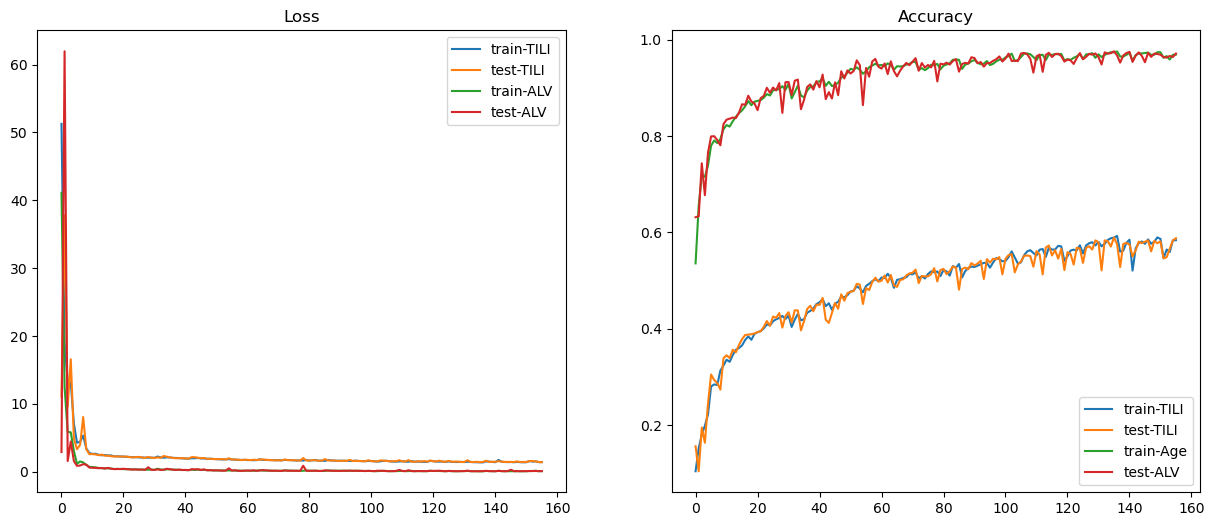

In [53]:
import matplotlib.pyplot as plt

# performance curve
plt.figure(figsize=(15,6))
epochs = history.epoch 
plt.subplot(1,2,1)
plt.plot(epochs, history.history['TILI_loss'], label = "train-TILI")
plt.plot(epochs, history.history['val_TILI_loss'], label = "test-TILI")
plt.plot(epochs, history.history['ALV-KOODI_loss'], label = "train-ALV")
plt.plot(epochs, history.history['val_ALV-KOODI_loss'], label = "test-ALV")
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history.history['TILI_sparse_categorical_accuracy'], label = "train-TILI")
plt.plot(epochs, history.history['val_TILI_sparse_categorical_accuracy'], label = "test-TILI")
plt.plot(epochs, history.history['ALV-KOODI_sparse_categorical_accuracy'], label = "train-Age")
plt.plot(epochs, history.history['val_ALV-KOODI_sparse_categorical_accuracy'], label = "test-ALV")
plt.title('Accuracy')
plt.legend()

The performance curve of the model shows that we do not have any problem of over or under fitting and also we can see that the model has converged smoothly.

In [54]:
# loading the best model
best_model = tf.keras.models.load_model('best_model')

In [55]:
# evaluate the test data

test_results = best_model.evaluate(test_data)

print(f'TILI - Loss: {test_results[1]}')
print(f'TILI - Accuracy: {test_results[3]}')
print()
print(f'ALV-KOODI - Loss: {test_results[2]}')
print(f'ALV-KOODI - Accuracy: {test_results[4]}')

61/61 [==============================] - 1s 5ms/step - loss: 1.4885 - TILI_loss: 1.4147 - ALV-KOODI_loss: 0.0738 - TILI_sparse_categorical_accuracy: 0.5894 - ALV-KOODI_sparse_categorical_accuracy: 0.9758
TILI - Loss: 1.4146554470062256
TILI - Accuracy: 0.5894351601600647

ALV-KOODI - Loss: 0.07380691915750504
ALV-KOODI - Accuracy: 0.9758122563362122


The evaluation result shows clearly that the model was very good in predicting the target feature 'ALV-KOODI' but performed poorly in predicting the feature 'TILI'. The reason for the poor prediction could be its higly skewed distribution. Therefore we could either perform more feature transformation on it or collect more data for better representation.